# Module Associations

**Created**: 20 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("UpSetR")) {
    install.packages("UpSetR")
}

Loading required namespace: patchwork

Loading required namespace: UpSetR



In [2]:
library(tidyverse)
library(RColorBrewer)
library(patchwork)
library(UpSetR)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [3]:
var.exp <- read.csv("~/gains_team282/nikhil/expression/gene_expression/variance.explained.csv")

est.cell.prop <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.cell.proportion.association.csv", row.names=1)
est.xcell <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.xcell.score.association.csv", row.names=1)
est.srsq <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.srsq.association.csv", row.names=1)
est.outcome <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.outcome.association.csv", row.names=1)
est.time.point <- read.csv("~/gains_team282/nikhil/expression/gene_expression/estimates.eigengene.time.point.association.csv", row.names=1)

## Create Combined Dataset

In [4]:
association.tbl <- dplyr::bind_rows(
  est.cell.prop, 
  est.xcell,
  est.srsq,
  est.outcome,
  est.time.point
)
rownames(association.tbl) <- NULL

write.csv(association.tbl, "~/gains_team282/nikhil/expression/gene_expression/estimates.all.csv", row.names=FALSE)

## Identify Shared Association Sets

In [13]:
association.sds <- association.tbl %>%
    dplyr::group_by(Association.Variable.Type) %>%
    dplyr::summarize(Mean=mean(Statistic), SD=sd(Statistic))

png 
  2

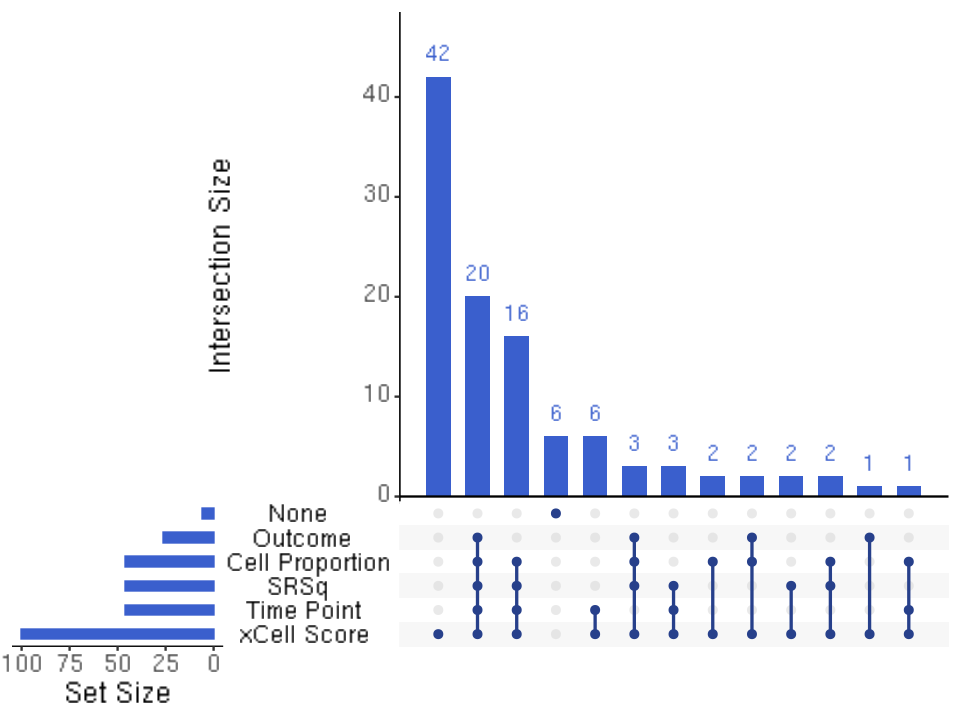

In [19]:
plot.data <- association.tbl %>%
  merge(., association.sds, by="Association.Variable.Type") %>%
  dplyr::filter(Adjusted.P.Value < 0.05, abs(Statistic - Mean) > SD)

plot.data <- split(plot.data, plot.data$Association.Variable.Type) %>%
  lapply(., function(x) unique(x[,"Eigengene"]))

plot.data[["None"]] <- setdiff(var.exp$Module, unique(unlist(plot.data)))

svg("04_Expression/results/eigengene_association_overlap.svg", width=8, height=6)
upset(
  fromList(plot.data), order.by="freq",
  matrix.color="royalblue4", main.bar.color="royalblue3", sets.bar.color="royalblue3",
  text.scale=2, nsets=6
)
dev.off()

options(repr.plot.width=8, repr.plot.height=6)
upset(
  fromList(plot.data), order.by="freq",
  matrix.color="royalblue4", main.bar.color="royalblue3", sets.bar.color="royalblue3",
  text.scale=2, nsets=6
)

In [6]:
# Identify Module Association Sets
modules <- Reduce(union, plot.data)

module.association.mtx <- lapply(modules, function(module.name) {
  return(sapply(plot.data, function(set) module.name %in% set))
}) %>%
  do.call(rbind, .) %>%
  as.data.frame()
rownames(module.association.mtx) <- modules

module.association.mtx %>%
    dplyr::filter(`Cell Proportion` & !Outcome & !SRSq & !`Time Point`)

,Cell Proportion,Outcome,SRSq,Time Point,xCell Score,None
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ME_98,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
ME_46,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE
